In [1]:
!nvidia-smi

Fri Jul 14 11:24:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:21:00.0 Off |                    0 |
| N/A   30C    P0    57W / 250W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
from pathlib import Path
from functools import partial

import torch

from gnn_tracking.training.ml import MLModule
from gnn_tracking.training.callbacks import PrintValidationMetrics
from gnn_tracking.models.graph_construction import GraphConstructionFCNN
from gnn_tracking.metrics.losses import GraphConstructionHingeEmbeddingLoss

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback, TQDMProgressBar
from gnn_tracking.utils.loading import TrackingDataModule
from gnn_tracking.utils.dictionaries import to_floats

from torch_geometric.data import Data
from torch import nn
from pytorch_lightning.core.mixins import HyperparametersMixin

import pandas as pd

In [3]:
val_dir = Path("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9")
assert val_dir.is_dir()

In [4]:
train_dirs = []
train_dir = Path("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/")
for i in range(1,9):
    d = os.path.join(train_dir, f"part_{i}")
    if os.path.isdir(d):
        train_dirs.append(d)

In [5]:
train_dirs

['/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_2',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_3',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_4',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_5',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_6',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_7',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_8']

In [6]:
dm = TrackingDataModule(
    train=dict(
        dirs=train_dirs,
        batch_size=1
    ),
    val=dict(
        dirs=[val_dir],
        stop=500,
    ),
    # could also configure a 'test' set here
)

In [7]:
# This is called by the Trainer automatically and sets up the datasets
dm.setup(stage="fit")  # 'fit' combines 'train' and 'val'
# Now the datasets are available:
dm.datasets

[11:25:03] INFO: DataLoader will load 7743 graphs (out of 7743 available).
[11:25:03] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_8/data28999_s0.pt
[11:25:03] INFO: DataLoader will load 500 graphs (out of 1000 available).
[11:25:03] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29499_s0.pt


{'train': TrackingDataset(7743), 'val': TrackingDataset(500)}

In [8]:
class CollectLossHistory(Callback):
    def __init__(self):
        self.data_list = []

    def on_validation_epoch_end(self, trainer, *args):
        if not trainer.sanity_checking:
            self.data_list.append(to_floats(trainer.callback_metrics))

    def get_history(self):
        return pd.DataFrame.from_records(self.data_list)

In [9]:
from torch.optim.lr_scheduler import StepLR

In [10]:
import matplotlib.pyplot as plt

In [11]:
import collections
from torch import Tensor
from gnn_tracking.utils.dictionaries import add_key_suffix

In [12]:
class MLModule_2(MLModule):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_history = []
        self.curr_loss = collections.defaultdict(lambda: 0.0)
    
    def training_step(self, batch: Data, batch_idx: int) -> Tensor | None:
        batch = self.data_preproc(batch)
        out = self(batch)
        loss, loss_dct = self.get_losses(out, batch)
        self.log_dict(add_key_suffix(loss_dct, "_train"), prog_bar=True, on_epoch=True, on_step=False,
                      batch_size=self.trainer.train_dataloader.batch_size)
        for k,v in loss_dct.items():
            self.curr_loss[f"{k}_train"] += v
        return loss
    
    def validation_step(self, batch: Data, batch_idx: int):
        batch = self.data_preproc(batch)
        out = self(batch)
        loss, loss_dct = self.get_losses(out, batch)
        self.log_dict_with_errors(
            loss_dct, batch_size=self.trainer.val_dataloaders.batch_size
        )
        if not self.trainer.sanity_checking:
            for k,v in loss_dct.items():
                self.curr_loss[f"{k}"] += v
        
    def on_validation_epoch_end(self, *args) -> None:
        self._log_errors()
        
        if self.trainer.sanity_checking:
            return
        
        loss_dict = {}
        for k,v in self.curr_loss.items():
            if k.endswith("_train"):
                loss_dict[k] = v/self.trainer.num_training_batches
            else:
                loss_dict[k] = v/self.trainer.num_val_batches[0]
            self.curr_loss[k] = 0.0
        
        self.loss_history.append(loss_dict)
    
    def get_loss_history(self):
        return pd.DataFrame.from_records(self.loss_history)

In [13]:
from gnn_tracking.utils.nomenclature import random_trial_name
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers import TensorBoardLogger

from wandb_osh.lightning_hooks import TriggerWandbSyncLightningCallback

In [14]:
name = random_trial_name()

─────────────────────────────── modest-wine-puma ───────────────────────────────

In [15]:
wandb_logger = WandbLogger(
    project="mdmm",
    group="graph-construction",
    offline=True,
    version=name,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id modest-wine-puma.


In [16]:
tb_logger = TensorBoardLogger(".", version=name)

In [19]:
def train_model(weight_repulsive, dm, max_epochs=50):

    model = GraphConstructionFCNN(in_dim=14, out_dim=8, depth=6, hidden_dim=512)

    lmodel = MLModule_2(
        model=model,
        loss_fct=GraphConstructionHingeEmbeddingLoss(p_attr=2, p_rep=2),
        lw_repulsive=weight_repulsive,
        optimizer=partial(torch.optim.Adam, lr=0.001),
    )

    loss_history_cb = CollectLossHistory()

    trainer = Trainer(max_epochs=max_epochs, accelerator="gpu",
                      log_every_n_steps=1, callbacks=[TriggerWandbSyncLightningCallback(),
                                                      PrintValidationMetrics(),
                                                      loss_history_cb,
                                                      TQDMProgressBar(refresh_rate=5)],
                      logger=[wandb_logger,tb_logger,])
    
    trainer.fit(model=lmodel, datamodule=dm)

    loss_history = loss_history_cb.get_history()
    loss_history_2 = lmodel.get_loss_history()
    return loss_history, loss_history_2

In [20]:
loss_history, loss_history_2 = train_model(weight_repulsive=0.001953029788887701, dm=dm, max_epochs=10)

11:29:31 INFO: This is wandb-osh v1.1.0 using communication directory /home/dc3896/.wandb_osh_command_dir
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[11:29:31] INFO: DataLoader will load 7743 graphs (out of 7743 available).
[11:29:31] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_8/data28999_s0.pt
[11:29:31] INFO: DataLoader will load 500 graphs (out of 1000 availab

Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
11:29:32 DEBUG: Wrote command file /home/dc3896/.wandb_osh_command_dir/c99145.command


             Validation epoch=1              
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric              ┃     Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ attractive          │   0.01034 │ 0.00015 │
│ attractive_weighted │   0.01034 │ 0.00015 │
│ repulsive           │ 220.34586 │ 1.75755 │
│ repulsive_weighted  │   0.43034 │ 0.00343 │
│ total               │   0.44068 │ 0.00358 │
└─────────────────────┴───────────┴─────────┘



/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

11:48:22 DEBUG: Wrote command file /home/dc3896/.wandb_osh_command_dir/c99145.command


             Validation epoch=1             
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric              ┃    Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ attractive          │  0.15029 │ 0.00091 │
│ attractive_weighted │  0.15029 │ 0.00091 │
│ repulsive           │ 65.42538 │ 0.26376 │
│ repulsive_weighted  │  0.12778 │ 0.00052 │
│ total               │  0.27806 │ 0.00108 │
└─────────────────────┴──────────┴─────────┘



Validation: 0it [00:00, ?it/s]

12:06:16 DEBUG: Wrote command file /home/dc3896/.wandb_osh_command_dir/c99145.command


                Validation epoch=2                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃    Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │  0.14143 │ 0.00054 │
│ attractive_train          │  0.21920 │     nan │
│ attractive_weighted       │  0.14143 │ 0.00054 │
│ attractive_weighted_train │  0.21920 │     nan │
│ repulsive                 │ 53.39483 │ 0.22921 │
│ repulsive_train           │ 98.39658 │     nan │
│ repulsive_weighted        │  0.10428 │ 0.00045 │
│ repulsive_weighted_train  │  0.19217 │     nan │
│ total                     │  0.24571 │ 0.00073 │
│ total_train               │  0.41137 │     nan │
└───────────────────────────┴──────────┴─────────┘



Validation: 0it [00:00, ?it/s]

12:23:39 DEBUG: Wrote command file /home/dc3896/.wandb_osh_command_dir/c99145.command


                Validation epoch=3                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃    Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │  0.10488 │ 0.00047 │
│ attractive_train          │  0.12423 │     nan │
│ attractive_weighted       │  0.10488 │ 0.00047 │
│ attractive_weighted_train │  0.12423 │     nan │
│ repulsive                 │ 42.49561 │ 0.18615 │
│ repulsive_train           │ 54.54250 │     nan │
│ repulsive_weighted        │  0.08300 │ 0.00036 │
│ repulsive_weighted_train  │  0.10652 │     nan │
│ total                     │  0.18787 │ 0.00062 │
│ total_train               │  0.23075 │     nan │
└───────────────────────────┴──────────┴─────────┘



Validation: 0it [00:00, ?it/s]

12:40:46 DEBUG: Wrote command file /home/dc3896/.wandb_osh_command_dir/c99145.command


                Validation epoch=4                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃    Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │  0.08099 │ 0.00043 │
│ attractive_train          │  0.10643 │     nan │
│ attractive_weighted       │  0.08099 │ 0.00043 │
│ attractive_weighted_train │  0.10643 │     nan │
│ repulsive                 │ 42.65965 │ 0.18651 │
│ repulsive_train           │ 46.68798 │     nan │
│ repulsive_weighted        │  0.08332 │ 0.00036 │
│ repulsive_weighted_train  │  0.09118 │     nan │
│ total                     │  0.16431 │ 0.00059 │
│ total_train               │  0.19761 │     nan │
└───────────────────────────┴──────────┴─────────┘



Validation: 0it [00:00, ?it/s]

12:57:43 DEBUG: Wrote command file /home/dc3896/.wandb_osh_command_dir/c99145.command


                Validation epoch=5                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃    Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │  0.07346 │ 0.00046 │
│ attractive_train          │  0.09712 │     nan │
│ attractive_weighted       │  0.07346 │ 0.00046 │
│ attractive_weighted_train │  0.09712 │     nan │
│ repulsive                 │ 39.18258 │ 0.17183 │
│ repulsive_train           │ 42.48894 │     nan │
│ repulsive_weighted        │  0.07652 │ 0.00034 │
│ repulsive_weighted_train  │  0.08298 │     nan │
│ total                     │  0.14998 │ 0.00059 │
│ total_train               │  0.18010 │     nan │
└───────────────────────────┴──────────┴─────────┘



Validation: 0it [00:00, ?it/s]

13:15:19 DEBUG: Wrote command file /home/dc3896/.wandb_osh_command_dir/c99145.command


                Validation epoch=6                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃    Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │  0.10252 │ 0.00046 │
│ attractive_train          │  0.09123 │     nan │
│ attractive_weighted       │  0.10252 │ 0.00046 │
│ attractive_weighted_train │  0.09123 │     nan │
│ repulsive                 │ 41.74807 │ 0.18312 │
│ repulsive_train           │ 39.92460 │     nan │
│ repulsive_weighted        │  0.08154 │ 0.00036 │
│ repulsive_weighted_train  │  0.07797 │     nan │
│ total                     │  0.18406 │ 0.00061 │
│ total_train               │  0.16921 │     nan │
└───────────────────────────┴──────────┴─────────┘



Validation: 0it [00:00, ?it/s]

13:32:13 DEBUG: Wrote command file /home/dc3896/.wandb_osh_command_dir/c99145.command


                Validation epoch=7                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃    Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │  0.07716 │ 0.00045 │
│ attractive_train          │  0.11772 │     nan │
│ attractive_weighted       │  0.07716 │ 0.00045 │
│ attractive_weighted_train │  0.11772 │     nan │
│ repulsive                 │ 36.74059 │ 0.16255 │
│ repulsive_train           │ 52.70134 │     nan │
│ repulsive_weighted        │  0.07176 │ 0.00032 │
│ repulsive_weighted_train  │  0.10293 │     nan │
│ total                     │  0.14892 │ 0.00058 │
│ total_train               │  0.22064 │     nan │
└───────────────────────────┴──────────┴─────────┘



Validation: 0it [00:00, ?it/s]

13:48:51 DEBUG: Wrote command file /home/dc3896/.wandb_osh_command_dir/c99145.command


                Validation epoch=8                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃    Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │  0.08096 │ 0.00044 │
│ attractive_train          │  0.09237 │     nan │
│ attractive_weighted       │  0.08096 │ 0.00044 │
│ attractive_weighted_train │  0.09237 │     nan │
│ repulsive                 │ 34.74887 │ 0.15453 │
│ repulsive_train           │ 40.91962 │     nan │
│ repulsive_weighted        │  0.06787 │ 0.00030 │
│ repulsive_weighted_train  │  0.07992 │     nan │
│ total                     │  0.14882 │ 0.00055 │
│ total_train               │  0.17228 │     nan │
└───────────────────────────┴──────────┴─────────┘



Validation: 0it [00:00, ?it/s]

14:05:18 DEBUG: Wrote command file /home/dc3896/.wandb_osh_command_dir/c99145.command


                Validation epoch=9                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃    Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │  0.07832 │ 0.00044 │
│ attractive_train          │  0.08268 │     nan │
│ attractive_weighted       │  0.07832 │ 0.00044 │
│ attractive_weighted_train │  0.08268 │     nan │
│ repulsive                 │ 33.40894 │ 0.14932 │
│ repulsive_train           │ 36.50113 │     nan │
│ repulsive_weighted        │  0.06525 │ 0.00029 │
│ repulsive_weighted_train  │  0.07129 │     nan │
│ total                     │  0.14356 │ 0.00054 │
│ total_train               │  0.15397 │     nan │
└───────────────────────────┴──────────┴─────────┘



Validation: 0it [00:00, ?it/s]

14:21:40 DEBUG: Wrote command file /home/dc3896/.wandb_osh_command_dir/c99145.command


`Trainer.fit` stopped: `max_epochs=10` reached.


               Validation epoch=10                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃    Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │  0.08776 │ 0.00051 │
│ attractive_train          │  0.07687 │     nan │
│ attractive_weighted       │  0.08776 │ 0.00051 │
│ attractive_weighted_train │  0.07687 │     nan │
│ repulsive                 │ 27.87493 │ 0.12575 │
│ repulsive_train           │ 33.75695 │     nan │
│ repulsive_weighted        │  0.05444 │ 0.00025 │
│ repulsive_weighted_train  │  0.06593 │     nan │
│ total                     │  0.14220 │ 0.00058 │
│ total_train               │  0.14280 │     nan │
└───────────────────────────┴──────────┴─────────┘



In [21]:
loss_history

,attractive,repulsive,attractive_weighted,repulsive_weighted,total,attractive_std,repulsive_std,attractive_weighted_std,repulsive_weighted_std,total_std,attractive_train,repulsive_train,attractive_weighted_train,repulsive_weighted_train,total_train
0,0.150287,65.425377,0.150287,0.127778,0.278065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.141433,53.394833,0.141433,0.104282,0.245715,0.000911,0.263757,0.000911,0.000515,0.001084,0.219199,98.396576,0.219199,0.192171,0.411370
2,0.104879,42.495609,0.104879,0.082995,0.187874,0.000537,0.229208,0.000537,0.000448,0.000726,0.124229,54.542500,0.124229,0.106523,0.230753
3,0.080993,42.659645,0.080993,0.083316,0.164308,0.000475,0.186154,0.000475,0.000364,0.000616,0.106431,46.687984,0.106431,0.091183,0.197614
4,0.073458,39.182583,0.073458,0.076525,0.149983,0.000434,0.186509,0.000434,0.000364,0.000587,0.097122,42.488941,0.097122,0.082982,0.180104
5,0.102523,41.748066,0.102523,0.081535,0.184059,0.000465,0.171830,0.000465,0.000336,0.000593,0.091233,39.924599,0.091233,0.077974,0.169207
6,0.077163,36.740585,0.077163,0.071755,0.148919,0.000462,0.183116,0.000462,0.000358,0.000607,0.117717,52.701340,0.117717,0.102928,0.220645
7,0.080959,34.748875,0.080959,0.067866,0.148824,0.000455,0.162555,0.000455,0.000317,0.000575,0.092368,40.919624,0.092368,0.079917,0.172284
8,0.078316,33.408943,0.078316,0.065249,0.143565,0.000444,0.154532,0.000444,0.000302,0.000550,0.082679,36.501125,0.082679,0.071288,0.153968
9,0.087757,27.874933,0.087757,0.054441,0.142198,0.000436,0.149322,0.000436,0.000292,0.000538,0.076872,33.756950,0.076872,0.065928,0.142801


In [22]:
loss_history_2

,attractive_train,repulsive_train,attractive_weighted_train,repulsive_weighted_train,total_train,attractive,repulsive,attractive_weighted,repulsive_weighted,total
0,0.219199,98.396459,0.219199,0.192171,0.411370,0.150287,65.425395,0.150287,0.127778,0.278065
1,0.124229,54.542654,0.124229,0.106523,0.230753,0.141433,53.394836,0.141433,0.104282,0.245715
2,0.106431,46.687959,0.106431,0.091183,0.197614,0.104879,42.495610,0.104879,0.082995,0.187874
3,0.097122,42.488977,0.097122,0.082982,0.180105,0.080993,42.659631,0.080993,0.083316,0.164309
4,0.091233,39.924526,0.091233,0.077974,0.169207,0.073458,39.182577,0.073458,0.076525,0.149983
5,0.117717,52.701438,0.117717,0.102927,0.220645,0.102523,41.748068,0.102523,0.081535,0.184059
6,0.092368,40.919655,0.092368,0.079917,0.172285,0.077163,36.740609,0.077163,0.071756,0.148919
7,0.082680,36.501123,0.082680,0.071288,0.153967,0.080959,34.748870,0.080959,0.067866,0.148824
8,0.076872,33.756986,0.076872,0.065928,0.142801,0.078316,33.408931,0.078316,0.065249,0.143565
9,0.073713,32.276105,0.073713,0.063036,0.136749,0.087757,27.874932,0.087757,0.054441,0.142198


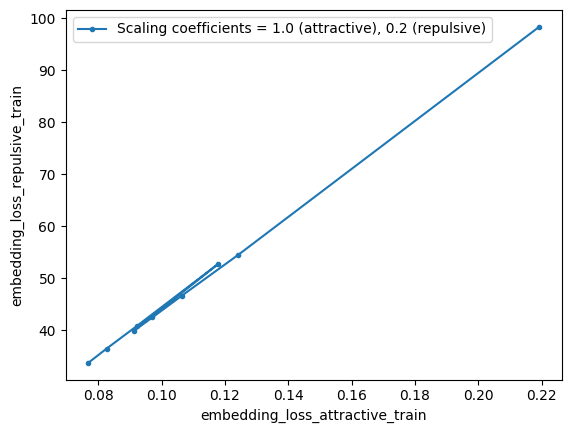

In [23]:
label = f'Scaling coefficients = {1.0} (attractive), {0.2} (repulsive)'
loss_history.plot(x='attractive_train', y='repulsive_train', marker='o', markersize=3, label=label)

plt.xlabel('embedding_loss_attractive_train')
plt.ylabel('embedding_loss_repulsive_train')

plt.legend()
plt.show()

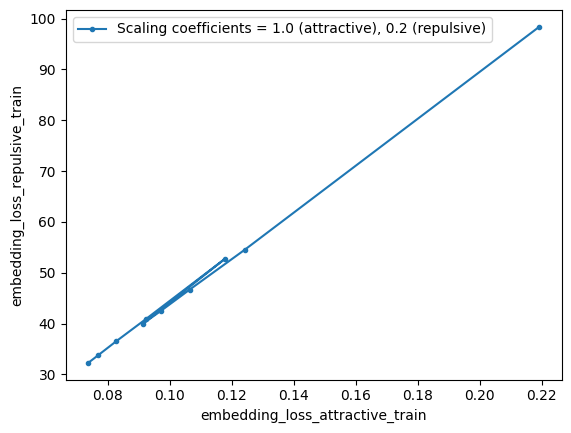

In [24]:
label = f'Scaling coefficients = {1.0} (attractive), {0.2} (repulsive)'
loss_history_2.plot(x='attractive_train', y='repulsive_train', marker='o', markersize=3, label=label)

plt.xlabel('embedding_loss_attractive_train')
plt.ylabel('embedding_loss_repulsive_train')

plt.legend()
plt.show()

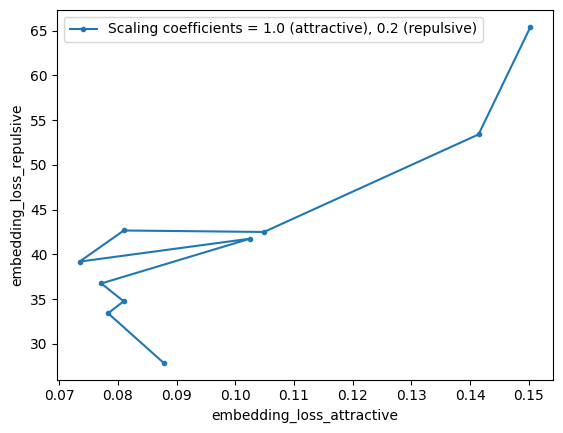

In [25]:
label = f'Scaling coefficients = {1.0} (attractive), {0.2} (repulsive)'
loss_history.plot(x='attractive', y='repulsive', marker='o', markersize=3, label=label)

plt.xlabel('embedding_loss_attractive')
plt.ylabel('embedding_loss_repulsive')

plt.legend()
plt.show()

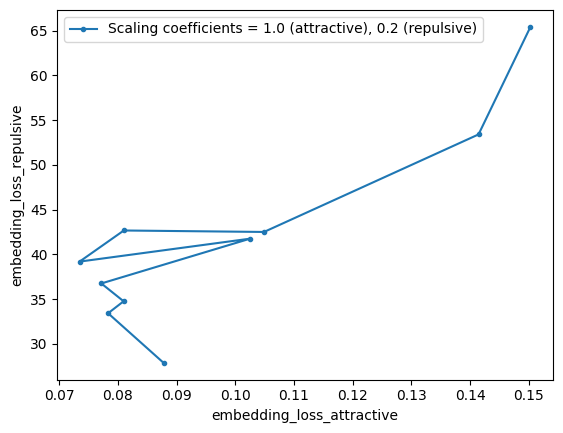

In [26]:
label = f'Scaling coefficients = {1.0} (attractive), {0.2} (repulsive)'
loss_history_2.plot(x='attractive', y='repulsive', marker='o', markersize=3, label=label)

plt.xlabel('embedding_loss_attractive')
plt.ylabel('embedding_loss_repulsive')

plt.legend()
plt.show()

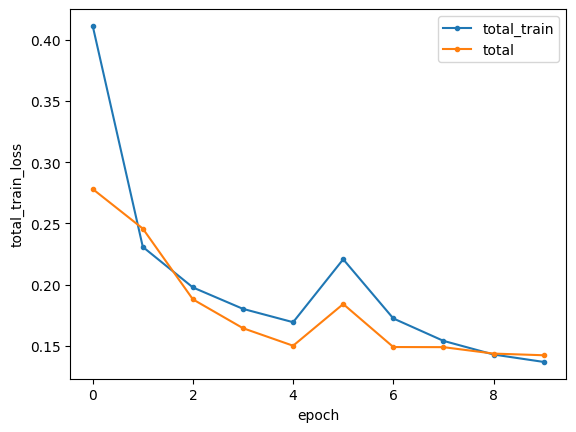

In [27]:
loss_history_2.plot(y=['total_train','total'], use_index=True, marker='o', markersize=3)

plt.xlabel('epoch')
plt.ylabel('total_train_loss')

plt.legend()
plt.show()

In [11]:
scaling_coeffs = [0.2, 0.5, 1.0, 2.0, 4.0]

In [12]:
models_dict = {}
for scaling_coeff in scaling_coeffs:
    print(f'Training for scaling coefficients = {scaling_coeff}')
    loss_history = train_model(weight_repulsive=scaling_coeff, dm=dm, max_epochs=20)
    models_dict[f'{scaling_coeff}'] = {'loss_history':loss_history,
                                       'weight_attractive':1,
                                       'weight_repulsive':scaling_coeff}
    print("\n")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training for scaling coefficients = 0.2


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[03:36:30] INFO: DataLoader will load 810 graphs (out of 900 available).
[03:36:30] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[03:36:30] INFO: DataLoader will load 90 graphs (out of 900 available).
[03:36:30] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_9/data21009_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt

Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

               Validation epoch=1                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00127 │ 0.00001 │
│ attractive_train          │ 0.00135 │     nan │
│ attractive_weighted       │ 0.00127 │ 0.00001 │
│ attractive_weighted_train │ 0.00135 │     nan │
│ repulsive                 │ 0.00254 │ 0.00004 │
│ repulsive_train           │ 0.00273 │     nan │
│ repulsive_weighted        │ 0.00051 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00055 │     nan │
│ total                     │ 0.00178 │ 0.00001 │
│ total_train               │ 0.00189 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=2                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00114 │ 0.00001 │
│ attractive_train          │ 0.00105 │     nan │
│ attractive_weighted       │ 0.00114 │ 0.00001 │
│ attractive_weighted_train │ 0.00105 │     nan │
│ repulsive                 │ 0.00220 │ 0.00004 │
│ repulsive_train           │ 0.00251 │     nan │
│ repulsive_weighted        │ 0.00044 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00050 │     nan │
│ total                     │ 0.00158 │ 0.00001 │
│ total_train               │ 0.00155 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=3                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00112 │ 0.00000 │
│ attractive_train          │ 0.00092 │     nan │
│ attractive_weighted       │ 0.00112 │ 0.00000 │
│ attractive_weighted_train │ 0.00092 │     nan │
│ repulsive                 │ 0.00213 │ 0.00003 │
│ repulsive_train           │ 0.00250 │     nan │
│ repulsive_weighted        │ 0.00043 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00050 │     nan │
│ total                     │ 0.00154 │ 0.00001 │
│ total_train               │ 0.00142 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=4                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00093 │ 0.00001 │
│ attractive_train          │ 0.00087 │     nan │
│ attractive_weighted       │ 0.00093 │ 0.00001 │
│ attractive_weighted_train │ 0.00087 │     nan │
│ repulsive                 │ 0.00173 │ 0.00003 │
│ repulsive_train           │ 0.00253 │     nan │
│ repulsive_weighted        │ 0.00035 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00051 │     nan │
│ total                     │ 0.00128 │ 0.00001 │
│ total_train               │ 0.00138 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=5                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00087 │ 0.00000 │
│ attractive_train          │ 0.00084 │     nan │
│ attractive_weighted       │ 0.00087 │ 0.00000 │
│ attractive_weighted_train │ 0.00084 │     nan │
│ repulsive                 │ 0.00190 │ 0.00003 │
│ repulsive_train           │ 0.00186 │     nan │
│ repulsive_weighted        │ 0.00038 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00037 │     nan │
│ total                     │ 0.00125 │ 0.00001 │
│ total_train               │ 0.00121 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=6                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00075 │ 0.00000 │
│ attractive_train          │ 0.00078 │     nan │
│ attractive_weighted       │ 0.00075 │ 0.00000 │
│ attractive_weighted_train │ 0.00078 │     nan │
│ repulsive                 │ 0.00179 │ 0.00003 │
│ repulsive_train           │ 0.00169 │     nan │
│ repulsive_weighted        │ 0.00036 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00034 │     nan │
│ total                     │ 0.00111 │ 0.00001 │
│ total_train               │ 0.00111 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=7                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00082 │ 0.00000 │
│ attractive_train          │ 0.00074 │     nan │
│ attractive_weighted       │ 0.00082 │ 0.00000 │
│ attractive_weighted_train │ 0.00074 │     nan │
│ repulsive                 │ 0.00144 │ 0.00002 │
│ repulsive_train           │ 0.00155 │     nan │
│ repulsive_weighted        │ 0.00029 │ 0.00000 │
│ repulsive_weighted_train  │ 0.00031 │     nan │
│ total                     │ 0.00110 │ 0.00001 │
│ total_train               │ 0.00105 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=8                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00078 │ 0.00000 │
│ attractive_train          │ 0.00069 │     nan │
│ attractive_weighted       │ 0.00078 │ 0.00000 │
│ attractive_weighted_train │ 0.00069 │     nan │
│ repulsive                 │ 0.00177 │ 0.00003 │
│ repulsive_train           │ 0.00196 │     nan │
│ repulsive_weighted        │ 0.00035 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00039 │     nan │
│ total                     │ 0.00113 │ 0.00001 │
│ total_train               │ 0.00109 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=9                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00072 │ 0.00000 │
│ attractive_train          │ 0.00076 │     nan │
│ attractive_weighted       │ 0.00072 │ 0.00000 │
│ attractive_weighted_train │ 0.00076 │     nan │
│ repulsive                 │ 0.00158 │ 0.00003 │
│ repulsive_train           │ 0.00126 │     nan │
│ repulsive_weighted        │ 0.00032 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00025 │     nan │
│ total                     │ 0.00103 │ 0.00001 │
│ total_train               │ 0.00102 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=10               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00066 │ 0.00000 │
│ attractive_train          │ 0.00077 │     nan │
│ attractive_weighted       │ 0.00066 │ 0.00000 │
│ attractive_weighted_train │ 0.00077 │     nan │
│ repulsive                 │ 0.00146 │ 0.00002 │
│ repulsive_train           │ 0.00132 │     nan │
│ repulsive_weighted        │ 0.00029 │ 0.00000 │
│ repulsive_weighted_train  │ 0.00026 │     nan │
│ total                     │ 0.00096 │ 0.00001 │
│ total_train               │ 0.00103 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=11               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00070 │ 0.00000 │
│ attractive_train          │ 0.00074 │     nan │
│ attractive_weighted       │ 0.00070 │ 0.00000 │
│ attractive_weighted_train │ 0.00074 │     nan │
│ repulsive                 │ 0.00150 │ 0.00002 │
│ repulsive_train           │ 0.00177 │     nan │
│ repulsive_weighted        │ 0.00030 │ 0.00000 │
│ repulsive_weighted_train  │ 0.00035 │     nan │
│ total                     │ 0.00100 │ 0.00001 │
│ total_train               │ 0.00110 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=12               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00063 │ 0.00000 │
│ attractive_train          │ 0.00066 │     nan │
│ attractive_weighted       │ 0.00063 │ 0.00000 │
│ attractive_weighted_train │ 0.00066 │     nan │
│ repulsive                 │ 0.00149 │ 0.00002 │
│ repulsive_train           │ 0.00143 │     nan │
│ repulsive_weighted        │ 0.00030 │ 0.00000 │
│ repulsive_weighted_train  │ 0.00029 │     nan │
│ total                     │ 0.00093 │ 0.00001 │
│ total_train               │ 0.00094 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=13               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00068 │ 0.00000 │
│ attractive_train          │ 0.00065 │     nan │
│ attractive_weighted       │ 0.00068 │ 0.00000 │
│ attractive_weighted_train │ 0.00065 │     nan │
│ repulsive                 │ 0.00142 │ 0.00002 │
│ repulsive_train           │ 0.00118 │     nan │
│ repulsive_weighted        │ 0.00028 │ 0.00000 │
│ repulsive_weighted_train  │ 0.00024 │     nan │
│ total                     │ 0.00097 │ 0.00001 │
│ total_train               │ 0.00089 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=14               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00064 │ 0.00000 │
│ attractive_train          │ 0.00061 │     nan │
│ attractive_weighted       │ 0.00064 │ 0.00000 │
│ attractive_weighted_train │ 0.00061 │     nan │
│ repulsive                 │ 0.00135 │ 0.00002 │
│ repulsive_train           │ 0.00139 │     nan │
│ repulsive_weighted        │ 0.00027 │ 0.00000 │
│ repulsive_weighted_train  │ 0.00028 │     nan │
│ total                     │ 0.00091 │ 0.00001 │
│ total_train               │ 0.00089 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=15               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00065 │ 0.00000 │
│ attractive_train          │ 0.00068 │     nan │
│ attractive_weighted       │ 0.00065 │ 0.00000 │
│ attractive_weighted_train │ 0.00068 │     nan │
│ repulsive                 │ 0.00144 │ 0.00002 │
│ repulsive_train           │ 0.00140 │     nan │
│ repulsive_weighted        │ 0.00029 │ 0.00000 │
│ repulsive_weighted_train  │ 0.00028 │     nan │
│ total                     │ 0.00094 │ 0.00001 │
│ total_train               │ 0.00096 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=16               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00065 │ 0.00000 │
│ attractive_train          │ 0.00061 │     nan │
│ attractive_weighted       │ 0.00065 │ 0.00000 │
│ attractive_weighted_train │ 0.00061 │     nan │
│ repulsive                 │ 0.00155 │ 0.00002 │
│ repulsive_train           │ 0.00132 │     nan │
│ repulsive_weighted        │ 0.00031 │ 0.00000 │
│ repulsive_weighted_train  │ 0.00026 │     nan │
│ total                     │ 0.00096 │ 0.00001 │
│ total_train               │ 0.00088 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=17               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00066 │ 0.00000 │
│ attractive_train          │ 0.00060 │     nan │
│ attractive_weighted       │ 0.00066 │ 0.00000 │
│ attractive_weighted_train │ 0.00060 │     nan │
│ repulsive                 │ 0.00135 │ 0.00002 │
│ repulsive_train           │ 0.00121 │     nan │
│ repulsive_weighted        │ 0.00027 │ 0.00000 │
│ repulsive_weighted_train  │ 0.00024 │     nan │
│ total                     │ 0.00093 │ 0.00001 │
│ total_train               │ 0.00084 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=18               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00060 │ 0.00000 │
│ attractive_train          │ 0.00065 │     nan │
│ attractive_weighted       │ 0.00060 │ 0.00000 │
│ attractive_weighted_train │ 0.00065 │     nan │
│ repulsive                 │ 0.00130 │ 0.00002 │
│ repulsive_train           │ 0.00133 │     nan │
│ repulsive_weighted        │ 0.00026 │ 0.00000 │
│ repulsive_weighted_train  │ 0.00027 │     nan │
│ total                     │ 0.00086 │ 0.00001 │
│ total_train               │ 0.00092 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=19               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00064 │ 0.00000 │
│ attractive_train          │ 0.00058 │     nan │
│ attractive_weighted       │ 0.00064 │ 0.00000 │
│ attractive_weighted_train │ 0.00058 │     nan │
│ repulsive                 │ 0.00133 │ 0.00002 │
│ repulsive_train           │ 0.00129 │     nan │
│ repulsive_weighted        │ 0.00027 │ 0.00000 │
│ repulsive_weighted_train  │ 0.00026 │     nan │
│ total                     │ 0.00091 │ 0.00001 │
│ total_train               │ 0.00084 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[03:38:16] INFO: DataLoader will load 810 graphs (out of 900 available).
[03:38:16] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[03:38:16] INFO: DataLoader will load 90 graphs (out of 900 available).
[03:38:16] DEBUG: First graph is 

               Validation epoch=20               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00058 │ 0.00000 │
│ attractive_train          │ 0.00057 │     nan │
│ attractive_weighted       │ 0.00058 │ 0.00000 │
│ attractive_weighted_train │ 0.00057 │     nan │
│ repulsive                 │ 0.00124 │ 0.00002 │
│ repulsive_train           │ 0.00111 │     nan │
│ repulsive_weighted        │ 0.00025 │ 0.00000 │
│ repulsive_weighted_train  │ 0.00022 │     nan │
│ total                     │ 0.00083 │ 0.00001 │
│ total_train               │ 0.00080 │     nan │
└───────────────────────────┴─────────┴─────────┘



Training for scaling coefficients = 0.5


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

               Validation epoch=1                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00188 │ 0.00001 │
│ attractive_train          │ 0.00182 │     nan │
│ attractive_weighted       │ 0.00188 │ 0.00001 │
│ attractive_weighted_train │ 0.00182 │     nan │
│ repulsive                 │ 0.00127 │ 0.00002 │
│ repulsive_train           │ 0.00117 │     nan │
│ repulsive_weighted        │ 0.00064 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00058 │     nan │
│ total                     │ 0.00252 │ 0.00001 │
│ total_train               │ 0.00241 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=2                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00159 │ 0.00001 │
│ attractive_train          │ 0.00150 │     nan │
│ attractive_weighted       │ 0.00159 │ 0.00001 │
│ attractive_weighted_train │ 0.00150 │     nan │
│ repulsive                 │ 0.00121 │ 0.00002 │
│ repulsive_train           │ 0.00130 │     nan │
│ repulsive_weighted        │ 0.00061 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00065 │     nan │
│ total                     │ 0.00220 │ 0.00001 │
│ total_train               │ 0.00215 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=3                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00144 │ 0.00001 │
│ attractive_train          │ 0.00153 │     nan │
│ attractive_weighted       │ 0.00144 │ 0.00001 │
│ attractive_weighted_train │ 0.00153 │     nan │
│ repulsive                 │ 0.00110 │ 0.00002 │
│ repulsive_train           │ 0.00099 │     nan │
│ repulsive_weighted        │ 0.00055 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00050 │     nan │
│ total                     │ 0.00199 │ 0.00001 │
│ total_train               │ 0.00203 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=4                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00132 │ 0.00001 │
│ attractive_train          │ 0.00132 │     nan │
│ attractive_weighted       │ 0.00132 │ 0.00001 │
│ attractive_weighted_train │ 0.00132 │     nan │
│ repulsive                 │ 0.00097 │ 0.00002 │
│ repulsive_train           │ 0.00103 │     nan │
│ repulsive_weighted        │ 0.00049 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00052 │     nan │
│ total                     │ 0.00181 │ 0.00001 │
│ total_train               │ 0.00184 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=5                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00113 │ 0.00001 │
│ attractive_train          │ 0.00114 │     nan │
│ attractive_weighted       │ 0.00113 │ 0.00001 │
│ attractive_weighted_train │ 0.00114 │     nan │
│ repulsive                 │ 0.00096 │ 0.00002 │
│ repulsive_train           │ 0.00113 │     nan │
│ repulsive_weighted        │ 0.00048 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00057 │     nan │
│ total                     │ 0.00161 │ 0.00001 │
│ total_train               │ 0.00171 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=6                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00116 │ 0.00001 │
│ attractive_train          │ 0.00115 │     nan │
│ attractive_weighted       │ 0.00116 │ 0.00001 │
│ attractive_weighted_train │ 0.00115 │     nan │
│ repulsive                 │ 0.00091 │ 0.00002 │
│ repulsive_train           │ 0.00101 │     nan │
│ repulsive_weighted        │ 0.00045 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00050 │     nan │
│ total                     │ 0.00161 │ 0.00001 │
│ total_train               │ 0.00165 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=7                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00113 │ 0.00001 │
│ attractive_train          │ 0.00100 │     nan │
│ attractive_weighted       │ 0.00113 │ 0.00001 │
│ attractive_weighted_train │ 0.00100 │     nan │
│ repulsive                 │ 0.00086 │ 0.00001 │
│ repulsive_train           │ 0.00089 │     nan │
│ repulsive_weighted        │ 0.00043 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00044 │     nan │
│ total                     │ 0.00156 │ 0.00001 │
│ total_train               │ 0.00144 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=8                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00107 │ 0.00001 │
│ attractive_train          │ 0.00101 │     nan │
│ attractive_weighted       │ 0.00107 │ 0.00001 │
│ attractive_weighted_train │ 0.00101 │     nan │
│ repulsive                 │ 0.00081 │ 0.00001 │
│ repulsive_train           │ 0.00093 │     nan │
│ repulsive_weighted        │ 0.00041 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00046 │     nan │
│ total                     │ 0.00147 │ 0.00001 │
│ total_train               │ 0.00147 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=9                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00097 │ 0.00001 │
│ attractive_train          │ 0.00097 │     nan │
│ attractive_weighted       │ 0.00097 │ 0.00001 │
│ attractive_weighted_train │ 0.00097 │     nan │
│ repulsive                 │ 0.00084 │ 0.00001 │
│ repulsive_train           │ 0.00072 │     nan │
│ repulsive_weighted        │ 0.00042 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00036 │     nan │
│ total                     │ 0.00139 │ 0.00001 │
│ total_train               │ 0.00134 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=10               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00107 │ 0.00001 │
│ attractive_train          │ 0.00097 │     nan │
│ attractive_weighted       │ 0.00107 │ 0.00001 │
│ attractive_weighted_train │ 0.00097 │     nan │
│ repulsive                 │ 0.00077 │ 0.00001 │
│ repulsive_train           │ 0.00098 │     nan │
│ repulsive_weighted        │ 0.00038 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00049 │     nan │
│ total                     │ 0.00145 │ 0.00001 │
│ total_train               │ 0.00145 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=11               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00091 │ 0.00001 │
│ attractive_train          │ 0.00092 │     nan │
│ attractive_weighted       │ 0.00091 │ 0.00001 │
│ attractive_weighted_train │ 0.00092 │     nan │
│ repulsive                 │ 0.00084 │ 0.00001 │
│ repulsive_train           │ 0.00075 │     nan │
│ repulsive_weighted        │ 0.00042 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00037 │     nan │
│ total                     │ 0.00133 │ 0.00001 │
│ total_train               │ 0.00129 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=12               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00091 │ 0.00001 │
│ attractive_train          │ 0.00097 │     nan │
│ attractive_weighted       │ 0.00091 │ 0.00001 │
│ attractive_weighted_train │ 0.00097 │     nan │
│ repulsive                 │ 0.00076 │ 0.00001 │
│ repulsive_train           │ 0.00077 │     nan │
│ repulsive_weighted        │ 0.00038 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00039 │     nan │
│ total                     │ 0.00129 │ 0.00001 │
│ total_train               │ 0.00136 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=13               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00083 │ 0.00001 │
│ attractive_train          │ 0.00087 │     nan │
│ attractive_weighted       │ 0.00083 │ 0.00001 │
│ attractive_weighted_train │ 0.00087 │     nan │
│ repulsive                 │ 0.00083 │ 0.00001 │
│ repulsive_train           │ 0.00067 │     nan │
│ repulsive_weighted        │ 0.00041 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00033 │     nan │
│ total                     │ 0.00124 │ 0.00001 │
│ total_train               │ 0.00120 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=14               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00088 │ 0.00001 │
│ attractive_train          │ 0.00081 │     nan │
│ attractive_weighted       │ 0.00088 │ 0.00001 │
│ attractive_weighted_train │ 0.00081 │     nan │
│ repulsive                 │ 0.00073 │ 0.00001 │
│ repulsive_train           │ 0.00078 │     nan │
│ repulsive_weighted        │ 0.00037 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00039 │     nan │
│ total                     │ 0.00124 │ 0.00001 │
│ total_train               │ 0.00120 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=15               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00082 │ 0.00001 │
│ attractive_train          │ 0.00080 │     nan │
│ attractive_weighted       │ 0.00082 │ 0.00001 │
│ attractive_weighted_train │ 0.00080 │     nan │
│ repulsive                 │ 0.00072 │ 0.00001 │
│ repulsive_train           │ 0.00092 │     nan │
│ repulsive_weighted        │ 0.00036 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00046 │     nan │
│ total                     │ 0.00118 │ 0.00001 │
│ total_train               │ 0.00126 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=16               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00086 │ 0.00001 │
│ attractive_train          │ 0.00087 │     nan │
│ attractive_weighted       │ 0.00086 │ 0.00001 │
│ attractive_weighted_train │ 0.00087 │     nan │
│ repulsive                 │ 0.00069 │ 0.00001 │
│ repulsive_train           │ 0.00069 │     nan │
│ repulsive_weighted        │ 0.00034 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00034 │     nan │
│ total                     │ 0.00120 │ 0.00001 │
│ total_train               │ 0.00121 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=17               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00079 │ 0.00001 │
│ attractive_train          │ 0.00088 │     nan │
│ attractive_weighted       │ 0.00079 │ 0.00001 │
│ attractive_weighted_train │ 0.00088 │     nan │
│ repulsive                 │ 0.00073 │ 0.00001 │
│ repulsive_train           │ 0.00078 │     nan │
│ repulsive_weighted        │ 0.00036 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00039 │     nan │
│ total                     │ 0.00116 │ 0.00001 │
│ total_train               │ 0.00127 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=18               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00080 │ 0.00001 │
│ attractive_train          │ 0.00080 │     nan │
│ attractive_weighted       │ 0.00080 │ 0.00001 │
│ attractive_weighted_train │ 0.00080 │     nan │
│ repulsive                 │ 0.00069 │ 0.00001 │
│ repulsive_train           │ 0.00075 │     nan │
│ repulsive_weighted        │ 0.00035 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00037 │     nan │
│ total                     │ 0.00115 │ 0.00001 │
│ total_train               │ 0.00118 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=19               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00084 │ 0.00001 │
│ attractive_train          │ 0.00077 │     nan │
│ attractive_weighted       │ 0.00084 │ 0.00001 │
│ attractive_weighted_train │ 0.00077 │     nan │
│ repulsive                 │ 0.00068 │ 0.00001 │
│ repulsive_train           │ 0.00083 │     nan │
│ repulsive_weighted        │ 0.00034 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00042 │     nan │
│ total                     │ 0.00118 │ 0.00001 │
│ total_train               │ 0.00118 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[03:39:50] INFO: DataLoader will load 810 graphs (out of 900 available).
[03:39:50] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[03:39:50] INFO: DataLoader will load 90 graphs (out of 900 available).
[03:39:50] DEBUG: First graph is 

               Validation epoch=20               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00080 │ 0.00001 │
│ attractive_train          │ 0.00081 │     nan │
│ attractive_weighted       │ 0.00080 │ 0.00001 │
│ attractive_weighted_train │ 0.00081 │     nan │
│ repulsive                 │ 0.00070 │ 0.00001 │
│ repulsive_train           │ 0.00075 │     nan │
│ repulsive_weighted        │ 0.00035 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00038 │     nan │
│ total                     │ 0.00115 │ 0.00001 │
│ total_train               │ 0.00119 │     nan │
└───────────────────────────┴─────────┴─────────┘



Training for scaling coefficients = 1.0


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

               Validation epoch=1                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00208 │ 0.00001 │
│ attractive_train          │ 0.00208 │     nan │
│ attractive_weighted       │ 0.00208 │ 0.00001 │
│ attractive_weighted_train │ 0.00208 │     nan │
│ repulsive                 │ 0.00074 │ 0.00001 │
│ repulsive_train           │ 0.00086 │     nan │
│ repulsive_weighted        │ 0.00074 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00086 │     nan │
│ total                     │ 0.00281 │ 0.00002 │
│ total_train               │ 0.00295 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=2                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00195 │ 0.00001 │
│ attractive_train          │ 0.00187 │     nan │
│ attractive_weighted       │ 0.00195 │ 0.00001 │
│ attractive_weighted_train │ 0.00187 │     nan │
│ repulsive                 │ 0.00061 │ 0.00001 │
│ repulsive_train           │ 0.00055 │     nan │
│ repulsive_weighted        │ 0.00061 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00055 │     nan │
│ total                     │ 0.00256 │ 0.00001 │
│ total_train               │ 0.00242 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=3                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00170 │ 0.00001 │
│ attractive_train          │ 0.00149 │     nan │
│ attractive_weighted       │ 0.00170 │ 0.00001 │
│ attractive_weighted_train │ 0.00149 │     nan │
│ repulsive                 │ 0.00050 │ 0.00001 │
│ repulsive_train           │ 0.00063 │     nan │
│ repulsive_weighted        │ 0.00050 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00063 │     nan │
│ total                     │ 0.00221 │ 0.00001 │
│ total_train               │ 0.00213 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=4                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00154 │ 0.00001 │
│ attractive_train          │ 0.00139 │     nan │
│ attractive_weighted       │ 0.00154 │ 0.00001 │
│ attractive_weighted_train │ 0.00139 │     nan │
│ repulsive                 │ 0.00060 │ 0.00001 │
│ repulsive_train           │ 0.00061 │     nan │
│ repulsive_weighted        │ 0.00060 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00061 │     nan │
│ total                     │ 0.00214 │ 0.00001 │
│ total_train               │ 0.00199 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=5                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00134 │ 0.00001 │
│ attractive_train          │ 0.00140 │     nan │
│ attractive_weighted       │ 0.00134 │ 0.00001 │
│ attractive_weighted_train │ 0.00140 │     nan │
│ repulsive                 │ 0.00057 │ 0.00001 │
│ repulsive_train           │ 0.00059 │     nan │
│ repulsive_weighted        │ 0.00057 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00059 │     nan │
│ total                     │ 0.00191 │ 0.00001 │
│ total_train               │ 0.00199 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=6                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00132 │ 0.00001 │
│ attractive_train          │ 0.00131 │     nan │
│ attractive_weighted       │ 0.00132 │ 0.00001 │
│ attractive_weighted_train │ 0.00131 │     nan │
│ repulsive                 │ 0.00049 │ 0.00001 │
│ repulsive_train           │ 0.00058 │     nan │
│ repulsive_weighted        │ 0.00049 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00058 │     nan │
│ total                     │ 0.00181 │ 0.00001 │
│ total_train               │ 0.00189 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=7                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00143 │ 0.00001 │
│ attractive_train          │ 0.00146 │     nan │
│ attractive_weighted       │ 0.00143 │ 0.00001 │
│ attractive_weighted_train │ 0.00146 │     nan │
│ repulsive                 │ 0.00050 │ 0.00001 │
│ repulsive_train           │ 0.00048 │     nan │
│ repulsive_weighted        │ 0.00050 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00048 │     nan │
│ total                     │ 0.00193 │ 0.00001 │
│ total_train               │ 0.00195 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=8                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00141 │ 0.00001 │
│ attractive_train          │ 0.00122 │     nan │
│ attractive_weighted       │ 0.00141 │ 0.00001 │
│ attractive_weighted_train │ 0.00122 │     nan │
│ repulsive                 │ 0.00056 │ 0.00001 │
│ repulsive_train           │ 0.00053 │     nan │
│ repulsive_weighted        │ 0.00056 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00053 │     nan │
│ total                     │ 0.00196 │ 0.00001 │
│ total_train               │ 0.00175 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=9                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00119 │ 0.00001 │
│ attractive_train          │ 0.00121 │     nan │
│ attractive_weighted       │ 0.00119 │ 0.00001 │
│ attractive_weighted_train │ 0.00121 │     nan │
│ repulsive                 │ 0.00051 │ 0.00001 │
│ repulsive_train           │ 0.00051 │     nan │
│ repulsive_weighted        │ 0.00051 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00051 │     nan │
│ total                     │ 0.00170 │ 0.00001 │
│ total_train               │ 0.00172 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=10               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00122 │ 0.00001 │
│ attractive_train          │ 0.00124 │     nan │
│ attractive_weighted       │ 0.00122 │ 0.00001 │
│ attractive_weighted_train │ 0.00124 │     nan │
│ repulsive                 │ 0.00046 │ 0.00001 │
│ repulsive_train           │ 0.00052 │     nan │
│ repulsive_weighted        │ 0.00046 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00052 │     nan │
│ total                     │ 0.00168 │ 0.00001 │
│ total_train               │ 0.00176 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=11               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00121 │ 0.00001 │
│ attractive_train          │ 0.00116 │     nan │
│ attractive_weighted       │ 0.00121 │ 0.00001 │
│ attractive_weighted_train │ 0.00116 │     nan │
│ repulsive                 │ 0.00049 │ 0.00001 │
│ repulsive_train           │ 0.00058 │     nan │
│ repulsive_weighted        │ 0.00049 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00058 │     nan │
│ total                     │ 0.00170 │ 0.00001 │
│ total_train               │ 0.00174 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=12               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00113 │ 0.00001 │
│ attractive_train          │ 0.00123 │     nan │
│ attractive_weighted       │ 0.00113 │ 0.00001 │
│ attractive_weighted_train │ 0.00123 │     nan │
│ repulsive                 │ 0.00045 │ 0.00001 │
│ repulsive_train           │ 0.00051 │     nan │
│ repulsive_weighted        │ 0.00045 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00051 │     nan │
│ total                     │ 0.00158 │ 0.00001 │
│ total_train               │ 0.00174 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=13               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00109 │ 0.00001 │
│ attractive_train          │ 0.00109 │     nan │
│ attractive_weighted       │ 0.00109 │ 0.00001 │
│ attractive_weighted_train │ 0.00109 │     nan │
│ repulsive                 │ 0.00048 │ 0.00001 │
│ repulsive_train           │ 0.00047 │     nan │
│ repulsive_weighted        │ 0.00048 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00047 │     nan │
│ total                     │ 0.00157 │ 0.00001 │
│ total_train               │ 0.00156 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=14               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00117 │ 0.00001 │
│ attractive_train          │ 0.00113 │     nan │
│ attractive_weighted       │ 0.00117 │ 0.00001 │
│ attractive_weighted_train │ 0.00113 │     nan │
│ repulsive                 │ 0.00046 │ 0.00001 │
│ repulsive_train           │ 0.00059 │     nan │
│ repulsive_weighted        │ 0.00046 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00059 │     nan │
│ total                     │ 0.00162 │ 0.00001 │
│ total_train               │ 0.00172 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=15               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00111 │ 0.00001 │
│ attractive_train          │ 0.00106 │     nan │
│ attractive_weighted       │ 0.00111 │ 0.00001 │
│ attractive_weighted_train │ 0.00106 │     nan │
│ repulsive                 │ 0.00048 │ 0.00001 │
│ repulsive_train           │ 0.00036 │     nan │
│ repulsive_weighted        │ 0.00048 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00036 │     nan │
│ total                     │ 0.00160 │ 0.00001 │
│ total_train               │ 0.00141 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=16               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00107 │ 0.00001 │
│ attractive_train          │ 0.00108 │     nan │
│ attractive_weighted       │ 0.00107 │ 0.00001 │
│ attractive_weighted_train │ 0.00108 │     nan │
│ repulsive                 │ 0.00041 │ 0.00001 │
│ repulsive_train           │ 0.00052 │     nan │
│ repulsive_weighted        │ 0.00041 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00052 │     nan │
│ total                     │ 0.00147 │ 0.00001 │
│ total_train               │ 0.00160 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=17               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00112 │ 0.00001 │
│ attractive_train          │ 0.00100 │     nan │
│ attractive_weighted       │ 0.00112 │ 0.00001 │
│ attractive_weighted_train │ 0.00100 │     nan │
│ repulsive                 │ 0.00042 │ 0.00001 │
│ repulsive_train           │ 0.00052 │     nan │
│ repulsive_weighted        │ 0.00042 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00052 │     nan │
│ total                     │ 0.00154 │ 0.00001 │
│ total_train               │ 0.00152 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=18               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00107 │ 0.00001 │
│ attractive_train          │ 0.00106 │     nan │
│ attractive_weighted       │ 0.00107 │ 0.00001 │
│ attractive_weighted_train │ 0.00106 │     nan │
│ repulsive                 │ 0.00042 │ 0.00001 │
│ repulsive_train           │ 0.00040 │     nan │
│ repulsive_weighted        │ 0.00042 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00040 │     nan │
│ total                     │ 0.00149 │ 0.00001 │
│ total_train               │ 0.00145 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=19               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00108 │ 0.00001 │
│ attractive_train          │ 0.00107 │     nan │
│ attractive_weighted       │ 0.00108 │ 0.00001 │
│ attractive_weighted_train │ 0.00107 │     nan │
│ repulsive                 │ 0.00041 │ 0.00001 │
│ repulsive_train           │ 0.00049 │     nan │
│ repulsive_weighted        │ 0.00041 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00049 │     nan │
│ total                     │ 0.00148 │ 0.00001 │
│ total_train               │ 0.00156 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[03:41:26] INFO: DataLoader will load 810 graphs (out of 900 available).
[03:41:26] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[03:41:26] INFO: DataLoader will load 90 graphs (out of 900 available).
[03:41:26] DEBUG: First graph is 

               Validation epoch=20               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00104 │ 0.00001 │
│ attractive_train          │ 0.00098 │     nan │
│ attractive_weighted       │ 0.00104 │ 0.00001 │
│ attractive_weighted_train │ 0.00098 │     nan │
│ repulsive                 │ 0.00039 │ 0.00001 │
│ repulsive_train           │ 0.00041 │     nan │
│ repulsive_weighted        │ 0.00039 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00041 │     nan │
│ total                     │ 0.00143 │ 0.00001 │
│ total_train               │ 0.00139 │     nan │
└───────────────────────────┴─────────┴─────────┘



Training for scaling coefficients = 2.0


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

               Validation epoch=1                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00259 │ 0.00001 │
│ attractive_train          │ 0.00249 │     nan │
│ attractive_weighted       │ 0.00259 │ 0.00001 │
│ attractive_weighted_train │ 0.00249 │     nan │
│ repulsive                 │ 0.00041 │ 0.00001 │
│ repulsive_train           │ 0.00035 │     nan │
│ repulsive_weighted        │ 0.00083 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00070 │     nan │
│ total                     │ 0.00342 │ 0.00002 │
│ total_train               │ 0.00319 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=2                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00228 │ 0.00001 │
│ attractive_train          │ 0.00249 │     nan │
│ attractive_weighted       │ 0.00228 │ 0.00001 │
│ attractive_weighted_train │ 0.00249 │     nan │
│ repulsive                 │ 0.00040 │ 0.00001 │
│ repulsive_train           │ 0.00031 │     nan │
│ repulsive_weighted        │ 0.00081 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00062 │     nan │
│ total                     │ 0.00309 │ 0.00002 │
│ total_train               │ 0.00311 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=3                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00206 │ 0.00001 │
│ attractive_train          │ 0.00214 │     nan │
│ attractive_weighted       │ 0.00206 │ 0.00001 │
│ attractive_weighted_train │ 0.00214 │     nan │
│ repulsive                 │ 0.00032 │ 0.00001 │
│ repulsive_train           │ 0.00039 │     nan │
│ repulsive_weighted        │ 0.00064 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00079 │     nan │
│ total                     │ 0.00270 │ 0.00001 │
│ total_train               │ 0.00292 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=4                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00194 │ 0.00001 │
│ attractive_train          │ 0.00187 │     nan │
│ attractive_weighted       │ 0.00194 │ 0.00001 │
│ attractive_weighted_train │ 0.00187 │     nan │
│ repulsive                 │ 0.00034 │ 0.00001 │
│ repulsive_train           │ 0.00034 │     nan │
│ repulsive_weighted        │ 0.00067 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00069 │     nan │
│ total                     │ 0.00261 │ 0.00001 │
│ total_train               │ 0.00256 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=5                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00177 │ 0.00001 │
│ attractive_train          │ 0.00199 │     nan │
│ attractive_weighted       │ 0.00177 │ 0.00001 │
│ attractive_weighted_train │ 0.00199 │     nan │
│ repulsive                 │ 0.00034 │ 0.00001 │
│ repulsive_train           │ 0.00033 │     nan │
│ repulsive_weighted        │ 0.00068 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00065 │     nan │
│ total                     │ 0.00245 │ 0.00001 │
│ total_train               │ 0.00265 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=6                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00178 │ 0.00001 │
│ attractive_train          │ 0.00182 │     nan │
│ attractive_weighted       │ 0.00178 │ 0.00001 │
│ attractive_weighted_train │ 0.00182 │     nan │
│ repulsive                 │ 0.00028 │ 0.00000 │
│ repulsive_train           │ 0.00027 │     nan │
│ repulsive_weighted        │ 0.00057 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00053 │     nan │
│ total                     │ 0.00235 │ 0.00001 │
│ total_train               │ 0.00236 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=7                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00160 │ 0.00001 │
│ attractive_train          │ 0.00174 │     nan │
│ attractive_weighted       │ 0.00160 │ 0.00001 │
│ attractive_weighted_train │ 0.00174 │     nan │
│ repulsive                 │ 0.00034 │ 0.00001 │
│ repulsive_train           │ 0.00023 │     nan │
│ repulsive_weighted        │ 0.00068 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00046 │     nan │
│ total                     │ 0.00229 │ 0.00001 │
│ total_train               │ 0.00220 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=8                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00165 │ 0.00001 │
│ attractive_train          │ 0.00172 │     nan │
│ attractive_weighted       │ 0.00165 │ 0.00001 │
│ attractive_weighted_train │ 0.00172 │     nan │
│ repulsive                 │ 0.00029 │ 0.00000 │
│ repulsive_train           │ 0.00027 │     nan │
│ repulsive_weighted        │ 0.00057 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00054 │     nan │
│ total                     │ 0.00222 │ 0.00001 │
│ total_train               │ 0.00227 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=9                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00172 │ 0.00001 │
│ attractive_train          │ 0.00177 │     nan │
│ attractive_weighted       │ 0.00172 │ 0.00001 │
│ attractive_weighted_train │ 0.00177 │     nan │
│ repulsive                 │ 0.00027 │ 0.00000 │
│ repulsive_train           │ 0.00024 │     nan │
│ repulsive_weighted        │ 0.00054 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00049 │     nan │
│ total                     │ 0.00226 │ 0.00001 │
│ total_train               │ 0.00225 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=10               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00163 │ 0.00001 │
│ attractive_train          │ 0.00151 │     nan │
│ attractive_weighted       │ 0.00163 │ 0.00001 │
│ attractive_weighted_train │ 0.00151 │     nan │
│ repulsive                 │ 0.00030 │ 0.00001 │
│ repulsive_train           │ 0.00029 │     nan │
│ repulsive_weighted        │ 0.00060 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00058 │     nan │
│ total                     │ 0.00223 │ 0.00001 │
│ total_train               │ 0.00209 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=11               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00144 │ 0.00001 │
│ attractive_train          │ 0.00152 │     nan │
│ attractive_weighted       │ 0.00144 │ 0.00001 │
│ attractive_weighted_train │ 0.00152 │     nan │
│ repulsive                 │ 0.00030 │ 0.00001 │
│ repulsive_train           │ 0.00032 │     nan │
│ repulsive_weighted        │ 0.00061 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00064 │     nan │
│ total                     │ 0.00204 │ 0.00001 │
│ total_train               │ 0.00215 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=12               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00151 │ 0.00001 │
│ attractive_train          │ 0.00141 │     nan │
│ attractive_weighted       │ 0.00151 │ 0.00001 │
│ attractive_weighted_train │ 0.00141 │     nan │
│ repulsive                 │ 0.00026 │ 0.00000 │
│ repulsive_train           │ 0.00025 │     nan │
│ repulsive_weighted        │ 0.00051 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00049 │     nan │
│ total                     │ 0.00202 │ 0.00001 │
│ total_train               │ 0.00190 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=13               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00150 │ 0.00001 │
│ attractive_train          │ 0.00149 │     nan │
│ attractive_weighted       │ 0.00150 │ 0.00001 │
│ attractive_weighted_train │ 0.00149 │     nan │
│ repulsive                 │ 0.00027 │ 0.00000 │
│ repulsive_train           │ 0.00034 │     nan │
│ repulsive_weighted        │ 0.00053 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00067 │     nan │
│ total                     │ 0.00203 │ 0.00001 │
│ total_train               │ 0.00216 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=14               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00136 │ 0.00001 │
│ attractive_train          │ 0.00152 │     nan │
│ attractive_weighted       │ 0.00136 │ 0.00001 │
│ attractive_weighted_train │ 0.00152 │     nan │
│ repulsive                 │ 0.00029 │ 0.00000 │
│ repulsive_train           │ 0.00025 │     nan │
│ repulsive_weighted        │ 0.00059 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00049 │     nan │
│ total                     │ 0.00195 │ 0.00001 │
│ total_train               │ 0.00201 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=15               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00141 │ 0.00001 │
│ attractive_train          │ 0.00139 │     nan │
│ attractive_weighted       │ 0.00141 │ 0.00001 │
│ attractive_weighted_train │ 0.00139 │     nan │
│ repulsive                 │ 0.00026 │ 0.00000 │
│ repulsive_train           │ 0.00026 │     nan │
│ repulsive_weighted        │ 0.00053 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00052 │     nan │
│ total                     │ 0.00193 │ 0.00001 │
│ total_train               │ 0.00192 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=16               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00143 │ 0.00001 │
│ attractive_train          │ 0.00143 │     nan │
│ attractive_weighted       │ 0.00143 │ 0.00001 │
│ attractive_weighted_train │ 0.00143 │     nan │
│ repulsive                 │ 0.00025 │ 0.00000 │
│ repulsive_train           │ 0.00031 │     nan │
│ repulsive_weighted        │ 0.00049 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00062 │     nan │
│ total                     │ 0.00192 │ 0.00001 │
│ total_train               │ 0.00205 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=17               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00132 │ 0.00001 │
│ attractive_train          │ 0.00128 │     nan │
│ attractive_weighted       │ 0.00132 │ 0.00001 │
│ attractive_weighted_train │ 0.00128 │     nan │
│ repulsive                 │ 0.00026 │ 0.00000 │
│ repulsive_train           │ 0.00029 │     nan │
│ repulsive_weighted        │ 0.00052 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00058 │     nan │
│ total                     │ 0.00184 │ 0.00001 │
│ total_train               │ 0.00187 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=18               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00130 │ 0.00001 │
│ attractive_train          │ 0.00124 │     nan │
│ attractive_weighted       │ 0.00130 │ 0.00001 │
│ attractive_weighted_train │ 0.00124 │     nan │
│ repulsive                 │ 0.00025 │ 0.00000 │
│ repulsive_train           │ 0.00021 │     nan │
│ repulsive_weighted        │ 0.00050 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00041 │     nan │
│ total                     │ 0.00180 │ 0.00001 │
│ total_train               │ 0.00165 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=19               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00134 │ 0.00001 │
│ attractive_train          │ 0.00134 │     nan │
│ attractive_weighted       │ 0.00134 │ 0.00001 │
│ attractive_weighted_train │ 0.00134 │     nan │
│ repulsive                 │ 0.00022 │ 0.00000 │
│ repulsive_train           │ 0.00030 │     nan │
│ repulsive_weighted        │ 0.00044 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00061 │     nan │
│ total                     │ 0.00179 │ 0.00001 │
│ total_train               │ 0.00195 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[03:43:00] INFO: DataLoader will load 810 graphs (out of 900 available).
[03:43:00] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[03:43:00] INFO: DataLoader will load 90 graphs (out of 900 available).
[03:43:00] DEBUG: First graph is 

               Validation epoch=20               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00128 │ 0.00001 │
│ attractive_train          │ 0.00133 │     nan │
│ attractive_weighted       │ 0.00128 │ 0.00001 │
│ attractive_weighted_train │ 0.00133 │     nan │
│ repulsive                 │ 0.00025 │ 0.00000 │
│ repulsive_train           │ 0.00027 │     nan │
│ repulsive_weighted        │ 0.00050 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00053 │     nan │
│ total                     │ 0.00179 │ 0.00001 │
│ total_train               │ 0.00186 │     nan │
└───────────────────────────┴─────────┴─────────┘



Training for scaling coefficients = 4.0


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

               Validation epoch=1                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00327 │ 0.00001 │
│ attractive_train          │ 0.00315 │     nan │
│ attractive_weighted       │ 0.00327 │ 0.00001 │
│ attractive_weighted_train │ 0.00315 │     nan │
│ repulsive                 │ 0.00025 │ 0.00000 │
│ repulsive_train           │ 0.00028 │     nan │
│ repulsive_weighted        │ 0.00099 │ 0.00002 │
│ repulsive_weighted_train  │ 0.00113 │     nan │
│ total                     │ 0.00425 │ 0.00002 │
│ total_train               │ 0.00429 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=2                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00272 │ 0.00001 │
│ attractive_train          │ 0.00270 │     nan │
│ attractive_weighted       │ 0.00272 │ 0.00001 │
│ attractive_weighted_train │ 0.00270 │     nan │
│ repulsive                 │ 0.00017 │ 0.00000 │
│ repulsive_train           │ 0.00022 │     nan │
│ repulsive_weighted        │ 0.00069 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00087 │     nan │
│ total                     │ 0.00341 │ 0.00002 │
│ total_train               │ 0.00356 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=3                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00255 │ 0.00001 │
│ attractive_train          │ 0.00249 │     nan │
│ attractive_weighted       │ 0.00255 │ 0.00001 │
│ attractive_weighted_train │ 0.00249 │     nan │
│ repulsive                 │ 0.00018 │ 0.00000 │
│ repulsive_train           │ 0.00023 │     nan │
│ repulsive_weighted        │ 0.00071 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00092 │     nan │
│ total                     │ 0.00326 │ 0.00002 │
│ total_train               │ 0.00341 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=4                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00245 │ 0.00001 │
│ attractive_train          │ 0.00258 │     nan │
│ attractive_weighted       │ 0.00245 │ 0.00001 │
│ attractive_weighted_train │ 0.00258 │     nan │
│ repulsive                 │ 0.00018 │ 0.00000 │
│ repulsive_train           │ 0.00019 │     nan │
│ repulsive_weighted        │ 0.00071 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00078 │     nan │
│ total                     │ 0.00317 │ 0.00002 │
│ total_train               │ 0.00335 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=5                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00243 │ 0.00001 │
│ attractive_train          │ 0.00248 │     nan │
│ attractive_weighted       │ 0.00243 │ 0.00001 │
│ attractive_weighted_train │ 0.00248 │     nan │
│ repulsive                 │ 0.00015 │ 0.00000 │
│ repulsive_train           │ 0.00017 │     nan │
│ repulsive_weighted        │ 0.00060 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00068 │     nan │
│ total                     │ 0.00303 │ 0.00002 │
│ total_train               │ 0.00316 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=6                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00230 │ 0.00001 │
│ attractive_train          │ 0.00225 │     nan │
│ attractive_weighted       │ 0.00230 │ 0.00001 │
│ attractive_weighted_train │ 0.00225 │     nan │
│ repulsive                 │ 0.00014 │ 0.00000 │
│ repulsive_train           │ 0.00015 │     nan │
│ repulsive_weighted        │ 0.00057 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00059 │     nan │
│ total                     │ 0.00287 │ 0.00001 │
│ total_train               │ 0.00284 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=7                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00224 │ 0.00001 │
│ attractive_train          │ 0.00230 │     nan │
│ attractive_weighted       │ 0.00224 │ 0.00001 │
│ attractive_weighted_train │ 0.00230 │     nan │
│ repulsive                 │ 0.00016 │ 0.00000 │
│ repulsive_train           │ 0.00016 │     nan │
│ repulsive_weighted        │ 0.00064 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00065 │     nan │
│ total                     │ 0.00288 │ 0.00001 │
│ total_train               │ 0.00296 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=8                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00221 │ 0.00001 │
│ attractive_train          │ 0.00232 │     nan │
│ attractive_weighted       │ 0.00221 │ 0.00001 │
│ attractive_weighted_train │ 0.00232 │     nan │
│ repulsive                 │ 0.00017 │ 0.00000 │
│ repulsive_train           │ 0.00014 │     nan │
│ repulsive_weighted        │ 0.00068 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00056 │     nan │
│ total                     │ 0.00289 │ 0.00002 │
│ total_train               │ 0.00288 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=9                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00208 │ 0.00001 │
│ attractive_train          │ 0.00193 │     nan │
│ attractive_weighted       │ 0.00208 │ 0.00001 │
│ attractive_weighted_train │ 0.00193 │     nan │
│ repulsive                 │ 0.00015 │ 0.00000 │
│ repulsive_train           │ 0.00019 │     nan │
│ repulsive_weighted        │ 0.00061 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00076 │     nan │
│ total                     │ 0.00268 │ 0.00001 │
│ total_train               │ 0.00269 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=10               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00200 │ 0.00001 │
│ attractive_train          │ 0.00214 │     nan │
│ attractive_weighted       │ 0.00200 │ 0.00001 │
│ attractive_weighted_train │ 0.00214 │     nan │
│ repulsive                 │ 0.00015 │ 0.00000 │
│ repulsive_train           │ 0.00015 │     nan │
│ repulsive_weighted        │ 0.00061 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00059 │     nan │
│ total                     │ 0.00261 │ 0.00001 │
│ total_train               │ 0.00272 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=11               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00200 │ 0.00001 │
│ attractive_train          │ 0.00202 │     nan │
│ attractive_weighted       │ 0.00200 │ 0.00001 │
│ attractive_weighted_train │ 0.00202 │     nan │
│ repulsive                 │ 0.00015 │ 0.00000 │
│ repulsive_train           │ 0.00015 │     nan │
│ repulsive_weighted        │ 0.00060 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00059 │     nan │
│ total                     │ 0.00259 │ 0.00001 │
│ total_train               │ 0.00261 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=12               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00196 │ 0.00001 │
│ attractive_train          │ 0.00193 │     nan │
│ attractive_weighted       │ 0.00196 │ 0.00001 │
│ attractive_weighted_train │ 0.00193 │     nan │
│ repulsive                 │ 0.00017 │ 0.00000 │
│ repulsive_train           │ 0.00016 │     nan │
│ repulsive_weighted        │ 0.00067 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00064 │     nan │
│ total                     │ 0.00262 │ 0.00002 │
│ total_train               │ 0.00257 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=13               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00179 │ 0.00001 │
│ attractive_train          │ 0.00192 │     nan │
│ attractive_weighted       │ 0.00179 │ 0.00001 │
│ attractive_weighted_train │ 0.00192 │     nan │
│ repulsive                 │ 0.00015 │ 0.00000 │
│ repulsive_train           │ 0.00014 │     nan │
│ repulsive_weighted        │ 0.00059 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00054 │     nan │
│ total                     │ 0.00237 │ 0.00001 │
│ total_train               │ 0.00247 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=14               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00184 │ 0.00001 │
│ attractive_train          │ 0.00175 │     nan │
│ attractive_weighted       │ 0.00184 │ 0.00001 │
│ attractive_weighted_train │ 0.00175 │     nan │
│ repulsive                 │ 0.00017 │ 0.00000 │
│ repulsive_train           │ 0.00018 │     nan │
│ repulsive_weighted        │ 0.00066 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00072 │     nan │
│ total                     │ 0.00250 │ 0.00001 │
│ total_train               │ 0.00246 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=15               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00181 │ 0.00001 │
│ attractive_train          │ 0.00167 │     nan │
│ attractive_weighted       │ 0.00181 │ 0.00001 │
│ attractive_weighted_train │ 0.00167 │     nan │
│ repulsive                 │ 0.00014 │ 0.00000 │
│ repulsive_train           │ 0.00018 │     nan │
│ repulsive_weighted        │ 0.00058 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00071 │     nan │
│ total                     │ 0.00239 │ 0.00001 │
│ total_train               │ 0.00237 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=16               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00174 │ 0.00001 │
│ attractive_train          │ 0.00173 │     nan │
│ attractive_weighted       │ 0.00174 │ 0.00001 │
│ attractive_weighted_train │ 0.00173 │     nan │
│ repulsive                 │ 0.00015 │ 0.00000 │
│ repulsive_train           │ 0.00011 │     nan │
│ repulsive_weighted        │ 0.00059 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00043 │     nan │
│ total                     │ 0.00233 │ 0.00001 │
│ total_train               │ 0.00216 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=17               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00172 │ 0.00001 │
│ attractive_train          │ 0.00169 │     nan │
│ attractive_weighted       │ 0.00172 │ 0.00001 │
│ attractive_weighted_train │ 0.00169 │     nan │
│ repulsive                 │ 0.00013 │ 0.00000 │
│ repulsive_train           │ 0.00014 │     nan │
│ repulsive_weighted        │ 0.00052 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00057 │     nan │
│ total                     │ 0.00224 │ 0.00001 │
│ total_train               │ 0.00226 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=18               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00180 │ 0.00001 │
│ attractive_train          │ 0.00185 │     nan │
│ attractive_weighted       │ 0.00180 │ 0.00001 │
│ attractive_weighted_train │ 0.00185 │     nan │
│ repulsive                 │ 0.00013 │ 0.00000 │
│ repulsive_train           │ 0.00014 │     nan │
│ repulsive_weighted        │ 0.00051 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00055 │     nan │
│ total                     │ 0.00231 │ 0.00001 │
│ total_train               │ 0.00239 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=19               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00172 │ 0.00001 │
│ attractive_train          │ 0.00180 │     nan │
│ attractive_weighted       │ 0.00172 │ 0.00001 │
│ attractive_weighted_train │ 0.00180 │     nan │
│ repulsive                 │ 0.00015 │ 0.00000 │
│ repulsive_train           │ 0.00014 │     nan │
│ repulsive_weighted        │ 0.00058 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00056 │     nan │
│ total                     │ 0.00230 │ 0.00001 │
│ total_train               │ 0.00236 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


               Validation epoch=20               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.00173 │ 0.00001 │
│ attractive_train          │ 0.00167 │     nan │
│ attractive_weighted       │ 0.00173 │ 0.00001 │
│ attractive_weighted_train │ 0.00167 │     nan │
│ repulsive                 │ 0.00015 │ 0.00000 │
│ repulsive_train           │ 0.00013 │     nan │
│ repulsive_weighted        │ 0.00058 │ 0.00001 │
│ repulsive_weighted_train  │ 0.00053 │     nan │
│ total                     │ 0.00231 │ 0.00001 │
│ total_train               │ 0.00220 │     nan │
└───────────────────────────┴─────────┴─────────┘





In [18]:
import matplotlib.pyplot as plt

In [19]:
plt.figure(figsize=(10, 6))

for key, model_dict in models_dict.items():
    label = f'Scaling coefficient = {model_dict["weight_attractive"]} (attractive), {model_dict["weight_repulsive"]} (repulsive)'
    plt.plot(model_dict['loss_history']['attractive_train'], 
             model_dict['loss_history']['repulsive_train'],
             marker='o', markersize=3, label=label)

plt.xlabel('embedding_loss_attractive_train')
plt.ylabel('embedding_loss_repulsive_train')
plt.title('Loss Functions')

plt.legend()
plt.show()

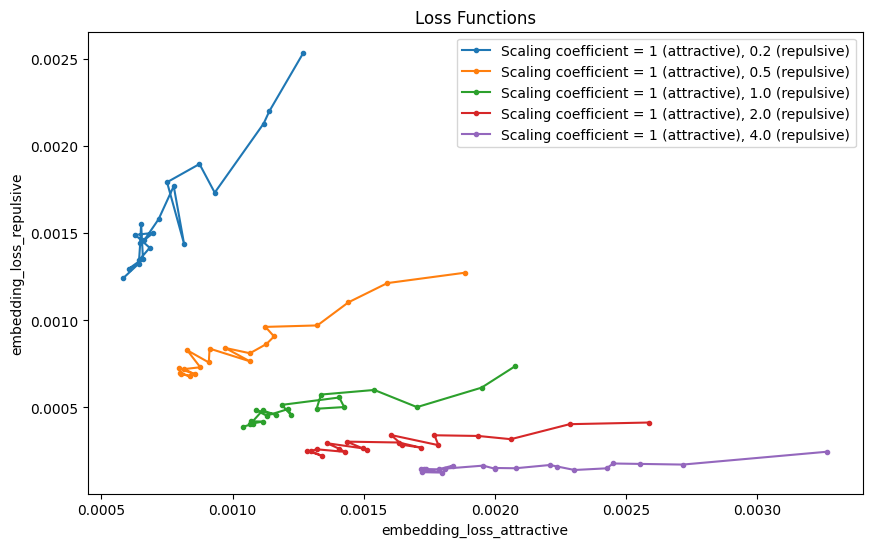

In [15]:
plt.figure(figsize=(10, 6))

for key, model_dict in models_dict.items():
    label = f'Scaling coefficient = {model_dict["weight_attractive"]} (attractive), {model_dict["weight_repulsive"]} (repulsive)'
    plt.plot(model_dict['loss_history']['attractive'], 
             model_dict['loss_history']['repulsive'],
             marker='o', markersize=3, label=label)

plt.xlabel('embedding_loss_attractive')
plt.ylabel('embedding_loss_repulsive')
plt.title('Loss Functions')

plt.legend()
plt.show()

In [18]:
for key, model_dict in models_dict.items():
    print(f'Scaling coefficient = {model_dict["weight_attractive"]} (attractive), {model_dict["weight_repulsive"]} (repulsive)')
    print(f"attractive_train = {model_dict['loss_history']['attractive_train'][-1]}") 
    print(f"repulsive_train = {model_dict['loss_history']['repulsive_train'][-1]}")
    print(f"attractive = {model_dict['loss_history']['attractive'][-1]}") 
    print(f"repulsive = {model_dict['loss_history']['repulsive'][-1]}")
    print('\n')

Scaling coefficient = 1 (attractive), 0.2 (repulsive)
attractive_train = 0.0005748728872276843
repulsive_train = 0.0011069910833612084
attractive = 0.0005817562923766673
repulsive = 0.0012404819717630744


Scaling coefficient = 1 (attractive), 0.5 (repulsive)
attractive_train = 0.0008114342344924808
repulsive_train = 0.0007505328394472599
attractive = 0.0007998778019100428
repulsive = 0.0006983964703977108


Scaling coefficient = 1 (attractive), 1.0 (repulsive)
attractive_train = 0.0009808961767703295
repulsive_train = 0.00041287270141765475
attractive = 0.001040896400809288
repulsive = 0.0003898827126249671


Scaling coefficient = 1 (attractive), 2.0 (repulsive)
attractive_train = 0.0013302370207384229
repulsive_train = 0.0002665876236278564
attractive = 0.0012832093052566051
repulsive = 0.0002523448783904314


Scaling coefficient = 1 (attractive), 4.0 (repulsive)
attractive_train = 0.0016745271859690547
repulsive_train = 0.00013125120312906802
attractive = 0.0017290508840233088
repul